In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import seaborn as sns


#### Preprocess the DataSet by creating a custom Dataset and splitting it into training and testing sets

Read the CSV file, preprocess it, and split it into training and testing sets.


In [81]:
# Load data
df = pd.read_csv('../combined_training_data_01.csv')

# Preprocess data
activity_features = df[['delta3_2', 'delta3_1', 'delta2_1']].values
activity_labels = df['label'].values

# Encode labels: Transform categorical labels into numerical values.
label_encoder = LabelEncoder()
# Fit: extract unique classes from dataset Transform: converts the labels to numerical values.
activity_labels = label_encoder.fit_transform(activity_labels)
# print(activity_labels)

# Normalize features: Fit: calculate mean and standard deviation for each feature; Transform: scale the features to have a mean = 0 and a standard deviation = 1.
scaler = StandardScaler()
activity_features = scaler.fit_transform(activity_features)
# print(activity_features)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(activity_features, activity_labels, test_size=0.2, random_state=42)

# Create custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, CD_features, CD_labels):
        self.features = torch.tensor(CD_features, dtype=torch.float32)
        self.labels = torch.tensor(CD_labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create data loaders
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

training_batch_size = 32
# Process the data in batches of 32 samples, Shuffle the batches to avoid overfitting (the mobel doesn't learn the order of the batches)
train_loader = DataLoader(train_dataset, batch_size=training_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=training_batch_size, shuffle=False)

#### Define the Neural Network architecture.

In [82]:
# Feed Forward Neural Network inherits from torch.nn.Module, base class of all NN in PyTorch
class SimpleNN(nn.Module):
    def __init__(self, NN_input_dim, NN_hidden_dim, NN_output_dim):
        super(SimpleNN, self).__init__()
        # First linear transformation layer 
        self.fc1 = nn.Linear(NN_input_dim, NN_hidden_dim)
        # Non-linear activation function 
        self.relu = nn.ReLU()
        # Linear transformation layer. NN_output_dim is the number of classes of our classification problem.
        self.fc2 = nn.Linear(NN_hidden_dim, NN_output_dim)
    
    # Defines the forward pass of the network
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Model parameters
input_dim = 3
hidden_dim = 64
output_dim = 9
# How much to change the model in response to the estimated error each time the model weights are updated.
learning_rate = 0.001

# Create instance of the NN
model = SimpleNN(input_dim, hidden_dim, output_dim)
# Loss function : measure how well the predicted class probabilities match the true labels
criterion = nn.CrossEntropyLoss()
# Optimizer to update the model’s parameters 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


#### Training Loop for the Neural Network

In [83]:
'''
Training loop for the Neural Network
'''
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Calculate and print loss: how well the models predictions match the actual target values (lower = better)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

print('Training finished')

Epoch [1/100], Loss: 0.6436
Epoch [2/100], Loss: 0.4793
Epoch [3/100], Loss: 0.4659
Epoch [4/100], Loss: 0.4607
Epoch [5/100], Loss: 0.4572
Epoch [6/100], Loss: 0.4548
Epoch [7/100], Loss: 0.4534
Epoch [8/100], Loss: 0.4519
Epoch [9/100], Loss: 0.4509
Epoch [10/100], Loss: 0.4498
Epoch [11/100], Loss: 0.4496
Epoch [12/100], Loss: 0.4482
Epoch [13/100], Loss: 0.4479
Epoch [14/100], Loss: 0.4469
Epoch [15/100], Loss: 0.4464
Epoch [16/100], Loss: 0.4465
Epoch [17/100], Loss: 0.4454
Epoch [18/100], Loss: 0.4457
Epoch [19/100], Loss: 0.4451
Epoch [20/100], Loss: 0.4446
Epoch [21/100], Loss: 0.4446
Epoch [22/100], Loss: 0.4448
Epoch [23/100], Loss: 0.4441
Epoch [24/100], Loss: 0.4441
Epoch [25/100], Loss: 0.4439
Epoch [26/100], Loss: 0.4432
Epoch [27/100], Loss: 0.4434
Epoch [28/100], Loss: 0.4430
Epoch [29/100], Loss: 0.4430
Epoch [30/100], Loss: 0.4423
Epoch [31/100], Loss: 0.4428
Epoch [32/100], Loss: 0.4426
Epoch [33/100], Loss: 0.4422
Epoch [34/100], Loss: 0.4422
Epoch [35/100], Loss: 0

#### Evaluate Model Accuracy

In [98]:
'''
Evaluate the trained NN on the test dataset to determine its accuracy.
'''

model.eval() # Evaluation mode
all_preds = []
all_labels = []
correct = 0
total = 0
with torch.no_grad(): # No gradient calculation, to save memory / compute time
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

print(f"Accuracy of the model on the test data:{accuracy_score(all_labels, all_preds)*100:.2f}%" )
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_, zero_division=0))


Accuracy of the model on the test data:87.16%
Classification Report:
              precision    recall  f1-score   support

         lay       0.97      0.98      0.97      1305
     lay_sit       0.10      0.01      0.01       172
   lay_stand       0.47      0.20      0.27       205
         sit       0.87      0.99      0.92      2767
     sit_lay       0.00      0.00      0.00        30
   sit_stand       0.47      0.09      0.16       247
       stand       0.92      0.94      0.93      3625
   stand_lay       0.60      0.67      0.63       508
   stand_sit       0.59      0.47      0.52       300

    accuracy                           0.87      9159
   macro avg       0.55      0.48      0.49      9159
weighted avg       0.84      0.87      0.85      9159



In [99]:
print(len(all_labels))
print(len(all_preds))


9159
9159


#### Evaluate Model Accuracy and plot Confusion Matrix

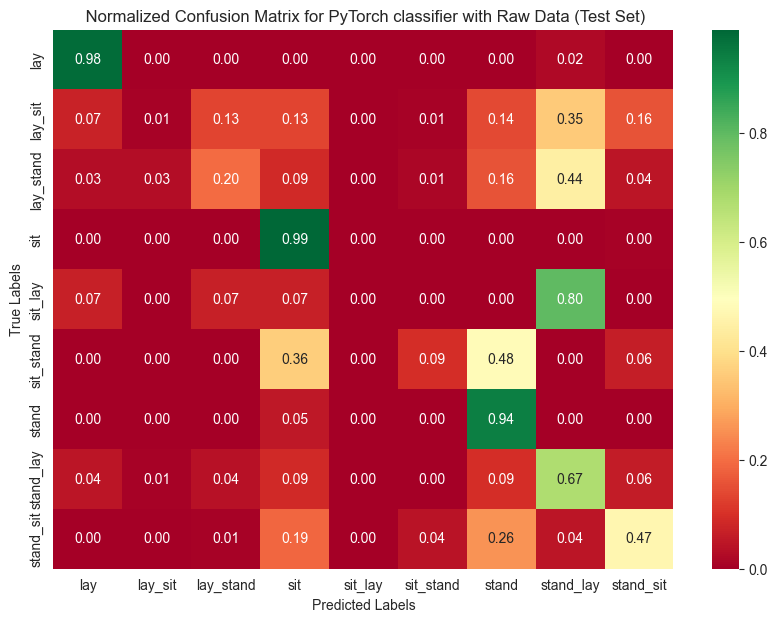

In [101]:
# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize the values along rows
row_sums = cm.sum(axis=1, keepdims=True)
column_sums = cm.sum(axis=1, keepdims=True)
cm_normalized = cm.astype('float') / np.where(row_sums != 0, row_sums, 1)

# Handle zero cases
cm_normalized[np.isnan(cm_normalized)] = 0

# Plot the confusion matrix
def plot_conf_matrix(conf_matrix, fmt, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt=fmt, cmap="RdYlGn", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# plot_conf_matrix(cm, 'd', 'Confusion Matrix for Random Forest with Raw Data (Test Set)')
plot_conf_matrix(cm_normalized, ".2f", ' Normalized Confusion Matrix for PyTorch classifier with Raw Data (Test Set)')

#### Predict unlabeled activity using the trained NN

In [86]:
all_preds = []
all_labels = []

# Function to classify unlabeled data
def classify_unlabeled_data(unlabeled_data_csv):
    df_unlabeled = pd.read_csv(unlabeled_data_csv)
    features_unlabeled = df_unlabeled[['delta3_2', 'delta3_1', 'delta2_1']].values
    
    # Normalize features
    features_unlabeled = scaler.transform(features_unlabeled)
    features_unlabeled = torch.tensor(features_unlabeled, dtype=torch.float32)
    
    true_labels = df_unlabeled['label']
    true_labels_enc = label_encoder.fit_transform(true_labels)

    model.eval()
    with torch.no_grad():
        outputs = model(features_unlabeled)
        _, predicted = torch.max(outputs.data, 1)
        
        predicted_labels = label_encoder.inverse_transform(predicted.numpy())
        df_unlabeled['predicted_label'] = predicted_labels
        
        all_preds.extend(predicted.numpy())
        all_labels.extend(true_labels_enc)

        return df_unlabeled, all_preds, all_labels

# classifying unlabeled data
unlabeled_data = '../combined_training_data_01.csv'
classified_data, predicted_labels, gt_labels = classify_unlabeled_data(unlabeled_data)
classified_data.to_csv('classified_data_NN_RD.csv', index=False)

In [95]:
print(len(gt_labels))
print(len(predicted_labels))


45792
45792


#### Confusion Matrix using the predicted data

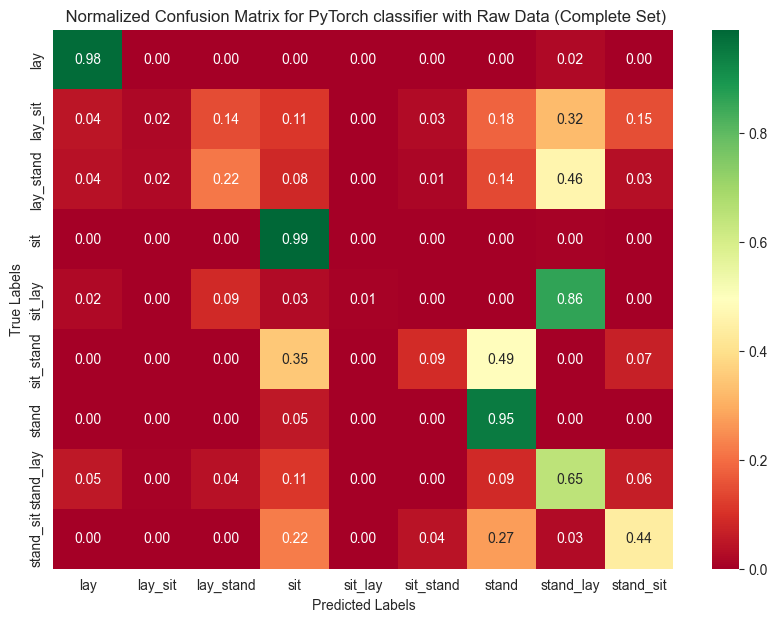

In [90]:
# Generate the confusion matrix
cm = confusion_matrix(gt_labels, predicted_labels)

# Normalize the values along rows
row_sums = cm.sum(axis=1, keepdims=True)
cm_normalized = cm.astype('float') / np.where(row_sums != 0, row_sums, 1)

# Handle zero cases
cm_normalized[np.isnan(cm_normalized)] = 0

# plot_conf_matrix(cm, 'd', 'Confusion Matrix for PyTorch classifier with Raw Data (Complete Set)')
plot_conf_matrix(cm_normalized, ".2f", ' Normalized Confusion Matrix for PyTorch classifier with Raw Data (Complete Set)')
